# Progetto del corso di Quantum Computing

## Caso base: immagine 4x4px

Iniziamo la trattazione con l'implementazione dell'algoritmo di base, nel caso di un'immagine $2^2 \times 2^2$ pixel.

### Import section

In [2]:
import numpy as np
from math import pi

# Grafici
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

L'immagine è volutamente dotata di repentini cambi verticali di intensità ogni 4 righe.

Height: 16, Width: 16


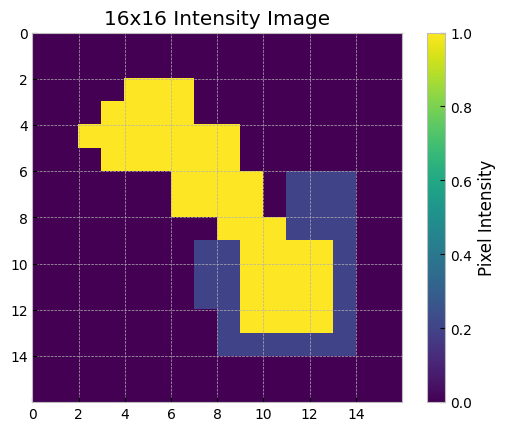

In [3]:
# #A 16x16 image with marked rows
# image = np.array([
#     [(i % 4) * 0.25 for j in range(16)]
#     for i in range(16)
# ]) 

# A 8x8 binary image
image = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0.2, 0.2, 0.2, 0, 0],
                  [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0.2, 0.2, 0.2, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0.2, 0.2, 0.2, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 1, 1, 1, 1, 0.2, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 1, 1, 1, 1, 0.2, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 1, 1, 1, 1, 0.2, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0.2, 1, 1, 1, 1, 0.2, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])



# Duplicare ogni elemento in un blocco 2x2 per ottenere un'immagine 16x16
# image = np.kron(image, np.ones((2, 2)))
height, width = image.shape
print(f"Height: {height}, Width: {width}")


# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(0, img.shape[0], 2))  # Show ticks every 2 pixels for clarity
    plt.yticks(range(0, img.shape[1], 2))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.colorbar(label="Pixel Intensity")
    plt.show()
    
plot_image(image, '16x16 Intensity Image')

Utilizziamo ora la _Quantum Probability Image Encoding_ (QPIE) per codificare le intensità dei pixel:

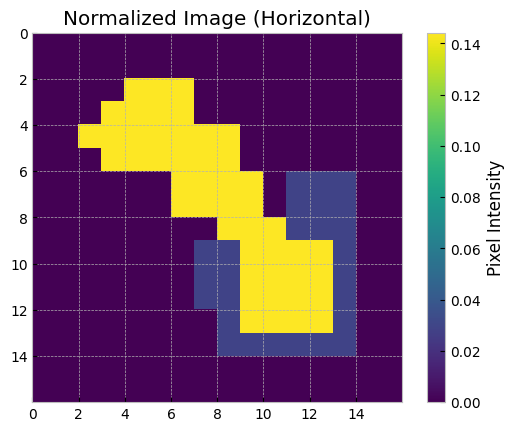

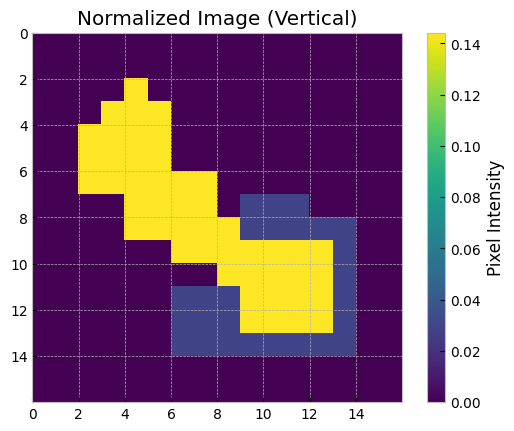

In [4]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

plot_image(image_norm_h.reshape(height, width), 'Normalized Image (Horizontal)')
plot_image(image_norm_v.reshape(height, width), 'Normalized Image (Vertical)')

In [5]:
# Initialize some global variable for number of qubits
data_qb = 8
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
print(D2n_1)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]


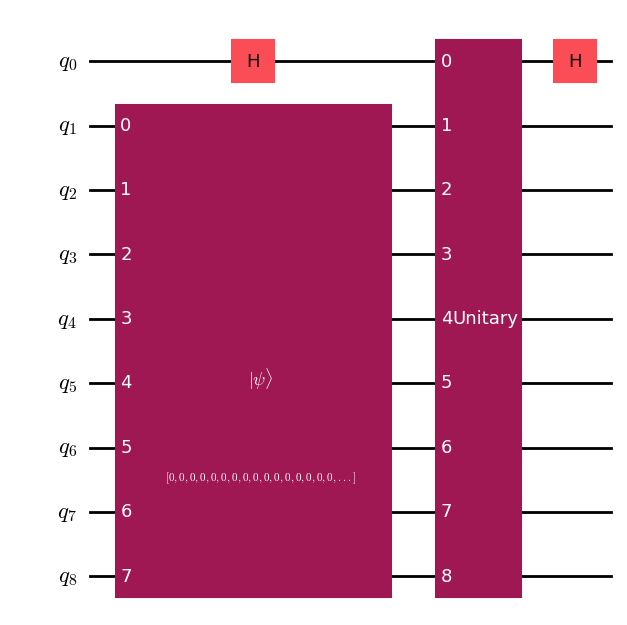

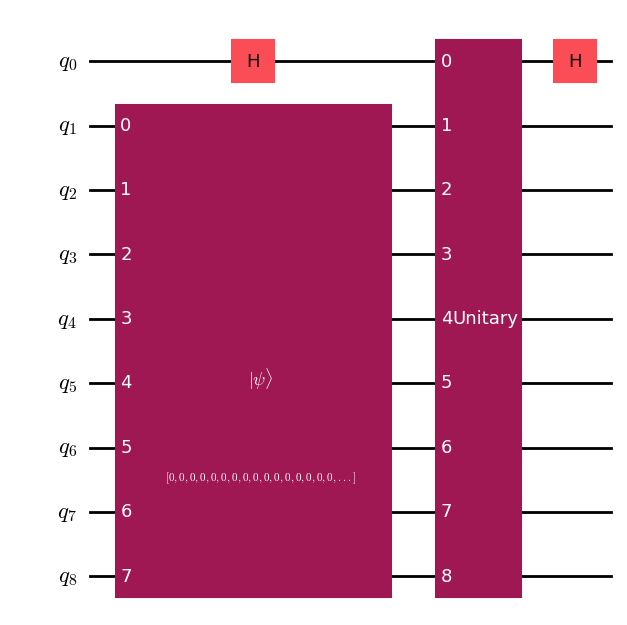

In [6]:
from qiskit import *
from qiskit import transpile
from qiskit_aer import Aer


# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [7]:
# Simulating the circuits
backend = Aer.get_backend('statevector_simulator')
new_circuit = transpile(circ_list, backend)

# Stampa dei circuiti dopo il transpile
# for idx, circuit in enumerate(new_circuit):
#     print(f"Circuito {idx + 1} dopo il transpiling:")
#     print(circuit.draw())

result = backend.run(new_circuit).result()
sv_h = np.array(result.get_statevector(qc_h))
sv_v = np.array(result.get_statevector(qc_v))

from qiskit.visualization import array_to_latex
print('Horizontal scan statevector:')
print(sv_h[:64])
#display(array_to_latex(sv_h[:30], max_size=30))
print()
print('Vertical scan statevector:')
print(sv_v[:64])
#display(array_to_latex(sv_v[:30], max_size=30))

Horizontal scan statevector:
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]

Vertical scan statevector:
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


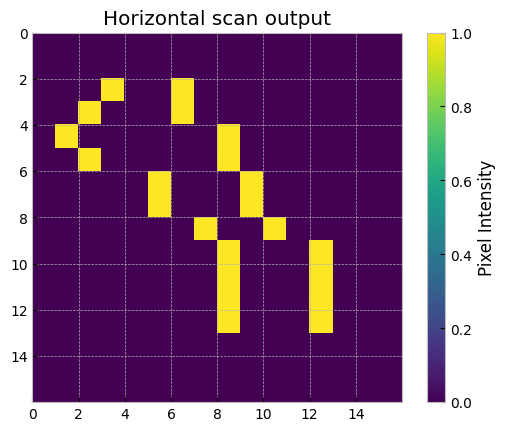

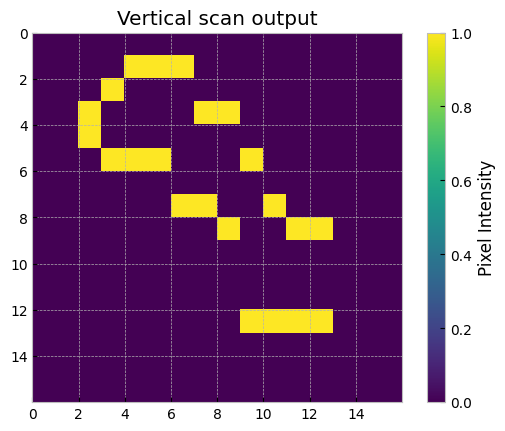

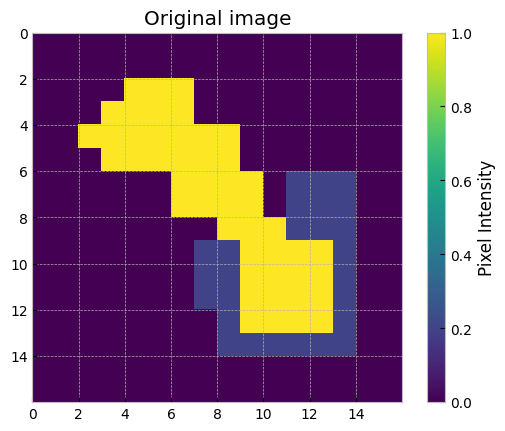

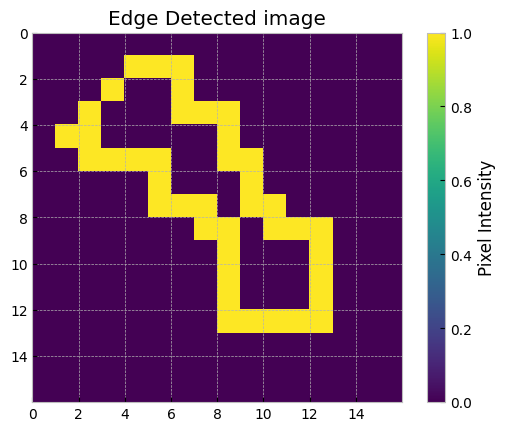

In [8]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
bound=4e-02
threshold = lambda amp: (amp > bound or amp < -bound)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(height, width)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(height, width).T

print(edge_scan_v)

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

## Error handling

Per iniziare, prendiamo un modello di rumore da un chip fisico (`ibm_kyiv`).

In [9]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel="ibm_quantum", token="cd9627c6de96e42618ed7038236b7d2bcff428e501b8f6866512731ad43cb60c57f5aff2822718b0e9b71c3d9bc58cda7d21994fe6ec88bbaf5ac128ce2715b3")
print(service.backends())

backend = service.backend("ibm_kyiv")
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
# Get basis gates from noise model
basis_gates = noise_model.basis_gates

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]


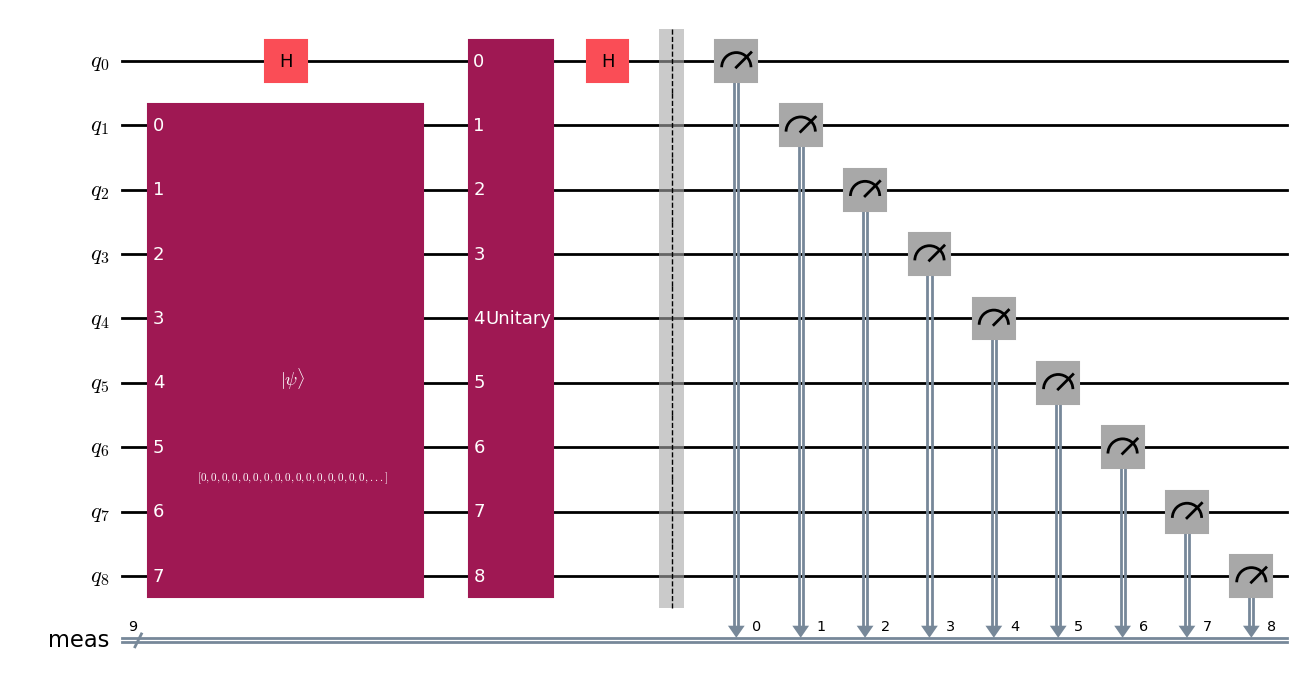

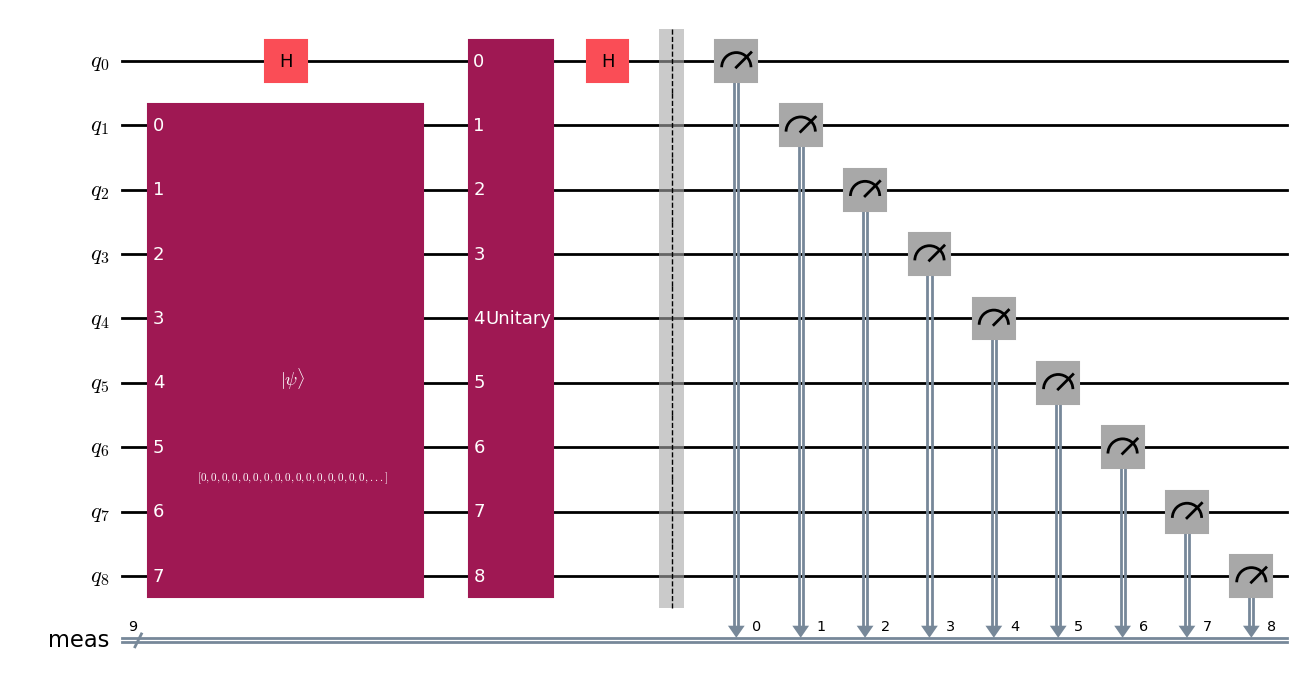

In [18]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
qc_h.measure_all()
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
qc_v.measure_all()
display(qc_v.draw('mpl', fold=-1))

# # Transpile the circuits for optimized execution on the backend
# qc_h_t = transpile(qc_h, backend=backend, optimization_level=3)
# qc_h_v = transpile(qc_v, backend=backend, optimization_level=3)
# print('transpiled!')

# Combine both circuits into a single list
# circ_list = [qc_h_t, qc_h_v]
circ_list = [qc_h, qc_v]

In [31]:
# Perform a noise simulation
backend = AerSimulator(
    noise_model=noise_model,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)

# Array per memorizzare i risultati intermedi
results_list = []

# Iterare su un ciclo per variare il numero di shots
for exponent in range(8, 24, 2):
    shots = 2 ** exponent
    print(f"Running simulation with {shots} shots...")
    
    # Eseguire la simulazione
    result = backend.run(circ_list, shots=shots).result()
    
    # Estrarre i conteggi
    counts_h = result.get_counts(qc_h)
    counts_v = result.get_counts(qc_v)
    
    # Salvare i risultati in un array
    results_list.append({
        'shots': shots,
        'counts_h': counts_h,
        'counts_v': counts_v
    })

Running simulation with 256 shots...
Running simulation with 1024 shots...
Running simulation with 4096 shots...
Running simulation with 16384 shots...
Running simulation with 65536 shots...
Running simulation with 262144 shots...
Running simulation with 1048576 shots...
Running simulation with 4194304 shots...


Processing results for 256 shots...
Processing results for 1024 shots...
Processing results for 4096 shots...
Processing results for 16384 shots...
Processing results for 65536 shots...
Processing results for 262144 shots...
Processing results for 1048576 shots...
Processing results for 4194304 shots...


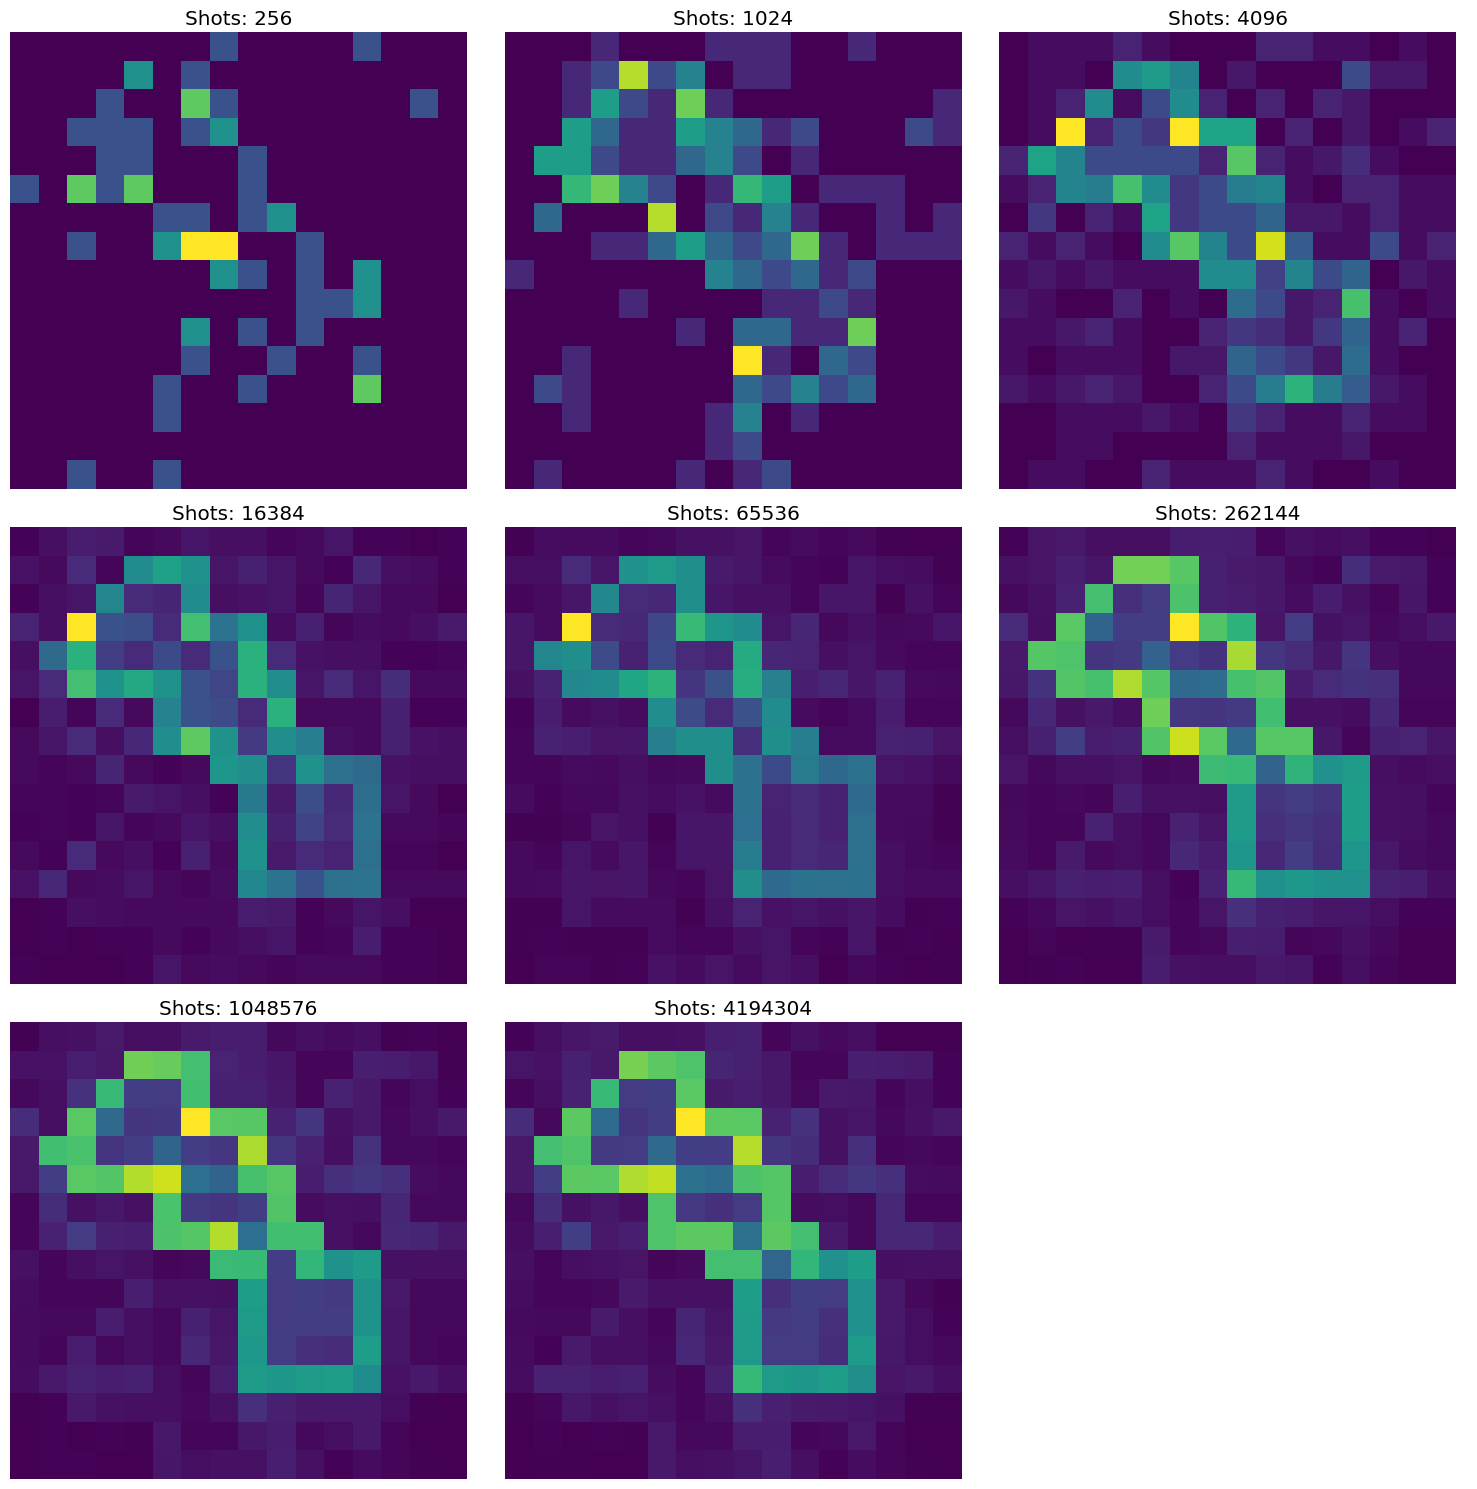

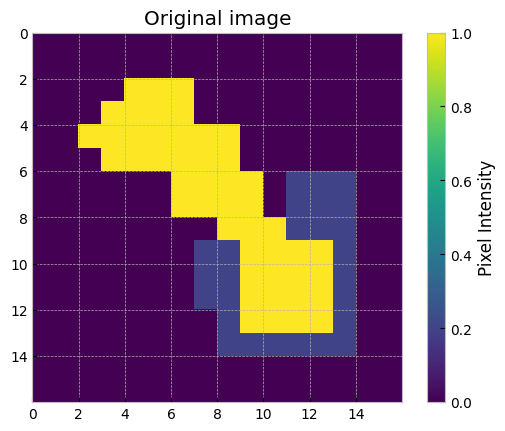

In [32]:
# edge_scan_h = np.array([
#     1 if counts_h.get(f'{2*i+1:09b}', 0) > 75 else 0
#     for i in range(2**data_qb)
# ]).reshape(height, width)

# edge_scan_v = np.array([
#     1 if counts_v.get(f'{2*i+1:09b}', 0) > 75 else 0
#     for i in range(2**data_qb)
# ]).reshape(height, width).T


import matplotlib.pyplot as plt

# Calcolo e memorizzazione delle immagini edge_detected
edge_detected_images = []
for result_data in results_list:
    shots = result_data['shots']
    counts_h = result_data['counts_h']
    counts_v = result_data['counts_v']
    
    print(f'Processing results for {shots} shots...')
    
    # Calcolare gli edge scan
    edge_scan_h = np.array([counts_h.get(f'{2*i+1:09b}', 0) for i in range(2**data_qb)]).reshape(height, width)
    edge_scan_v = np.array([counts_v.get(f'{2*i+1:09b}', 0) for i in range(2**data_qb)]).reshape(height, width).T
    
    # Determinare l'immagine dei bordi
    edge_detected_image = edge_scan_h | edge_scan_v
    edge_detected_images.append((shots, edge_detected_image))

# Creazione del grafico a griglia
num_images = len(edge_detected_images)
cols = 3  # Numero di colonne nella griglia
rows = (num_images + cols - 1) // cols  # Calcolo del numero di righe necessario

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Imposta la dimensione del grafico

# Per assicurarsi che `axes` sia sempre un array bidimensionale
axes = np.array(axes).reshape(rows, cols)

# Popolare la griglia con le immagini
for idx, (shots, edge_detected_image) in enumerate(edge_detected_images):
    row, col = divmod(idx, cols)
    ax = axes[row, col]
    ax.imshow(edge_detected_image)  # Mostra l'immagine
    ax.set_title(f'Shots: {shots}')
    ax.axis('off')  # Rimuovi assi per un layout pulito

# Rimuovere i riquadri vuoti (se presenti)
for idx in range(num_images, rows * cols):
    row, col = divmod(idx, cols)
    axes[row, col].axis('off')

plt.tight_layout()  # Migliora la spaziatura
plt.show()
plot_image(image, 'Original image')
